In [1]:
#################################################################
## Foresight deep learning challenge 2021                       ##
## author: Vered Silverman                                      ###
## Diparity maps using openCV bloch-matching
## then compare with results from RAFT (VeredSil_RAFT.ipynb)
##################################################################

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import glob
from numpy import save


def calc_disparity_cvStereoBM(imgL, imgR, minDis = 0, blockSize = 17, numDisp = 16*4):
    # generate disparity map using openCV block-matching 
    # imgL,imgR - left/right stereo pair loaded with cv.imread
    
    stereo = cv.StereoBM_create(numDisparities=numDisp, blockSize=blockSize)
    stereo.setMinDisparity(minDis)
    stereo.setSpeckleRange(5)
    stereo.setSpeckleWindowSize(5)
    stereo.setPreFilterType(0)
    stereo.setDisp12MaxDiff(3)
    stereo.setUniquenessRatio(20)
    stereo.setPreFilterSize(9)
    disparity = stereo.compute(imgL, imgR)#, disptype = 'CV_32F')
    disparity_grayscale = (disparity-disparity.min())*(65535.0/(disparity.max()-disparity.min()))

    return disparity, disparity_grayscale, stereo


def load_LR_images(impathL):
    # load setero images and distance map for one scenario, loaded with cv.imread
    # input: impathL - path to left stereo image 
    # returns: imgL, imgR, dist, img_suffx (indicating the numerical index of the loaded frames)
    psthstr = impathL.split('/')[0]
    img_suffx = impathL.split('_')[-1].split('.png')[0]
    impathR = impathL.replace("left", "right")
    imgL = cv.imread(impathL ,cv.IMREAD_GRAYSCALE)
    imgR = cv.imread(impathR ,cv.IMREAD_GRAYSCALE)
    dist = cv.imread('%s/dist_%s.png'%(psthstr, img_suffx), cv.IMREAD_UNCHANGED)
    dist.astype(np.uint16)
            
    return imgL, imgR, dist, img_suffx



/work/silverv/anaconda3/envs/raft/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


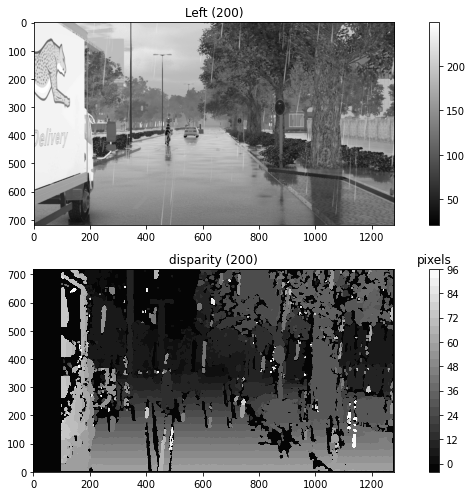

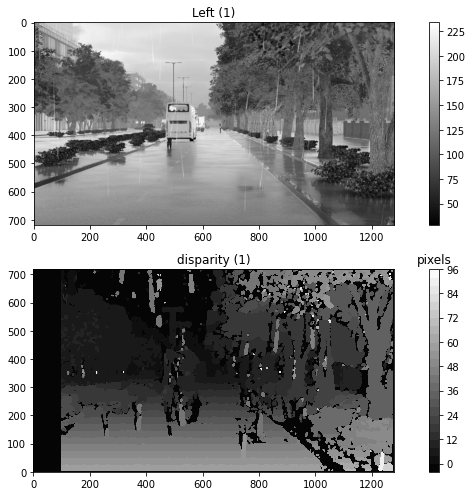

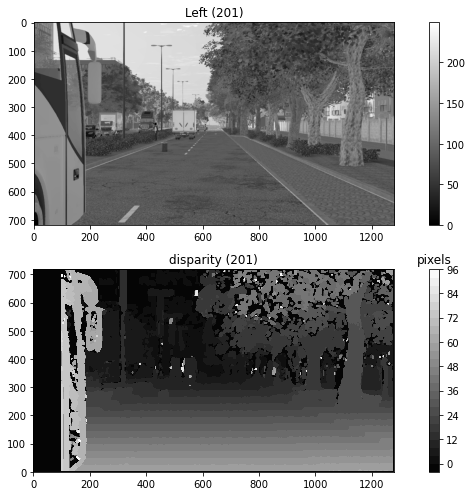

In [3]:
# Generate disparity maps for all stereo image pairs

numDisp = 16*6
blockSize = 11
minDis = 0
eps = 1e-5
cmap = 'gray'

images = glob.glob('framesRAW/VL_left_*.png')

for imfileL in images:
    
    # load images
    imgL, imgR, dist, img_suffx = load_LR_images(imfileL)
    # calculated disparity for left frame
    disparity, disparity_norm, stereoL = calc_disparity_cvStereoBM(imgL, imgR, minDis = minDis, blockSize = blockSize, numDisp = numDisp)
    # need to divide disparity by  16 to get values in pixel units
    
    # plot left image and disparity
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,7), tight_layout=True)
    iax = 0
    cfi = axes[iax].imshow(imgL,'gray')
    fig.colorbar(cfi, ax= axes[iax])
    axes[iax].set_title('Left (%s)'%img_suffx)
    axes[iax].set(aspect='equal')

    iax += 1
    cf = axes[iax].contourf(disparity[::-1,:]/16, 30, cmap = cmap); 
    cax = fig.colorbar(cf, ax= axes[iax])
    cax.ax.set_title('pixels')
    axes[iax].set_title('disparity (%s)'%img_suffx)
    axes[iax].set(aspect='equal')

    plt.show()
    
    np.save('disparity_cv2BM_img%s.npy'%(img_suffx), disparity)
    np.save('dist_img%s.npy'%(img_suffx), dist)
    fig.savefig('resultsHW/disparity_cvStereoBM_mind%d_nd%02d_bs%02d_img%s_slim.png'%(minDis, numDisp, blockSize, img_suffx), dpi=100)
   



/work/silverv/anaconda3/envs/raft/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/work/silverv/anaconda3/envs/raft/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


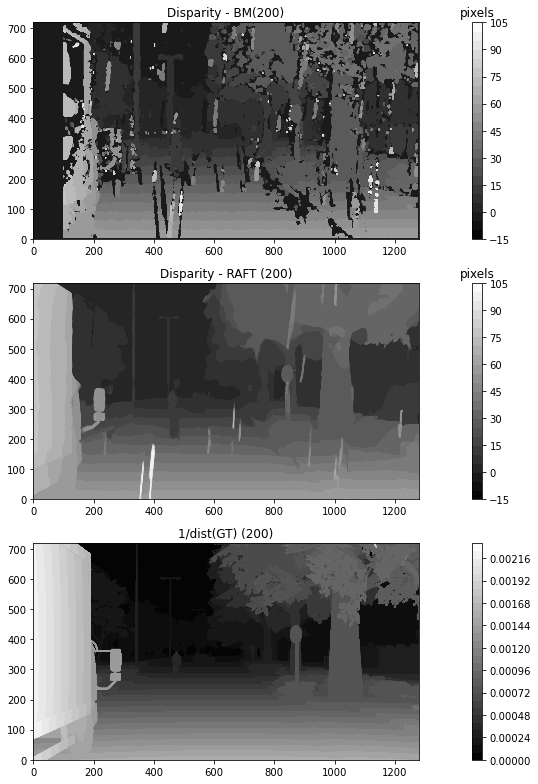

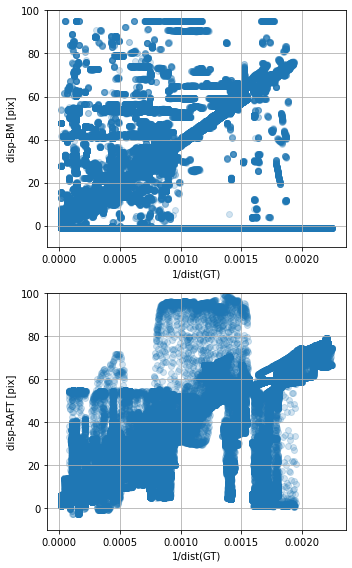

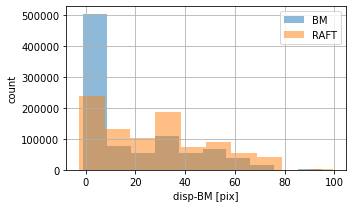

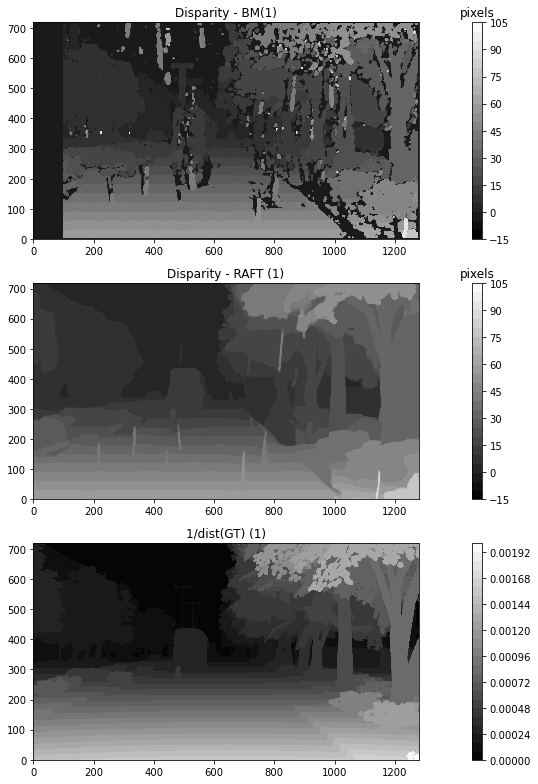

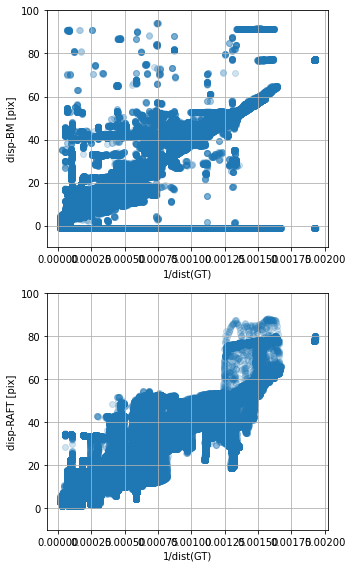

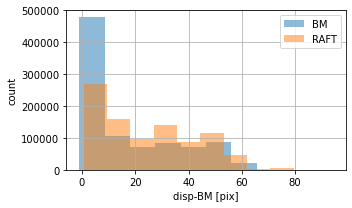

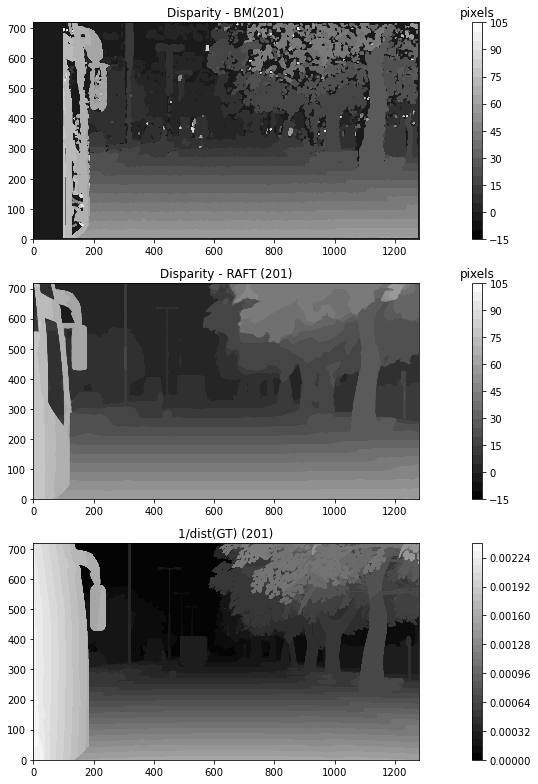

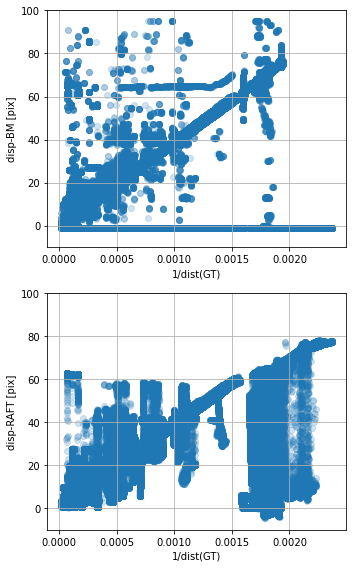

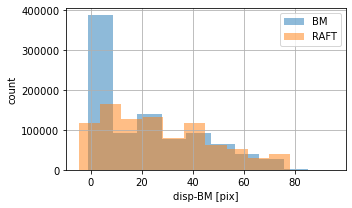

In [55]:
## Compare results from disparity maps generated with BM and RAFT
## !! run this after step 2 which calculates the distarity map using RAFT 

# contour levels for disp plotting
clevs = np.arange(-15, 110, 5)

for imfileL in images:
    # load images
    imgL, imgR, dist, img_suffx = load_LR_images(imfileL)
    disparity = np.load('disparity_cv2BM_img%s.npy'%(img_suffx)) # load results from BM
    disp_raft = np.load('disparity_raft-sintel_img%s.npy'%(img_suffx))[0,:,:] # load results from RAFT
    dist = np.load('dist_img%s.npy'%(img_suffx)) # load distance map

    # plot for comparison:
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15,11), tight_layout=True)
    iax = 0
    cf = axes[iax].contourf(disparity[::-1,:]/16, clevs, cmap = cmap); 
    cax = fig.colorbar(cf, ax= axes[iax])
    cax.ax.set_title('pixels')
    axes[iax].set_title('Disparity - BM(%s)'%img_suffx)
    axes[iax].set(aspect='equal')
    
    iax += 1
    cfi = axes[iax].contourf(disp_raft[::-1,:], clevs, cmap = cmap)
    cax = fig.colorbar(cfi, ax= axes[iax])
    cax.ax.set_title('pixels')
    axes[iax].set_title('Disparity - RAFT (%s)'%img_suffx)
    axes[iax].set(aspect='equal')
    
    iax += 1
    inv_dist = 1/dist
    inv_dist[np.where(dist==0)] = 0
    cfi = axes[iax].contourf(inv_dist[::-1,:], 30, cmap = cmap)
    fig.colorbar(cfi, ax= axes[iax])
    axes[iax].set_title('1/dist(GT) (%s)'%img_suffx)
    axes[iax].set(aspect='equal')
    
    fig.savefig('resultsHW/disparity_RAFT_VS_cvStereoBM_mind%d_nd%02d_bs%02d_img%s.png'%(minDis, numDisp, blockSize, img_suffx), dpi=100)

    # now plot disparity VS 1/distance to evaluate performance
    plothist_dist = 1/dist.reshape(-1,)
    plothist_bm = disparity.reshape(-1,)/16 # divide by 16 to get BM results in pixels
    plothist_raft = disp_raft.reshape(-1,)

    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (5,8), tight_layout=True)
    iax = 0
    axes[iax].scatter(plothist_dist, plothist_bm, alpha=.2)
    axes[iax].grid()
    axes[iax].set_ylim([-10,100])
    axes[iax].set_ylabel('disp-BM [pix]')
    axes[iax].set_xlabel('1/dist(GT)')

    iax +=1
    axes[iax].scatter(plothist_dist, plothist_raft, alpha=.2)
    axes[iax].grid()
    axes[iax].set_ylim([-10,100])
    axes[iax].set_ylabel('disp-RAFT [pix]')
    axes[iax].set_xlabel('1/dist(GT)')

    fig.savefig('resultsHW/scatter_disparity_RAFT_VS_cvStereoBM_mind%d_nd%02d_bs%02d_img%s.png'%(minDis, numDisp, blockSize, img_suffx), dpi=100)

    # plot hist of disp values to compare their distribution
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), tight_layout=True)
    axes.hist(plothist_bm, alpha=.5, label='BM')
    axes.hist(plothist_raft, alpha=.5, label='RAFT')
    axes.grid()
    axes.set_xlabel('disp-BM [pix]')
    axes.set_ylabel('count')
    axes.legend()
    fig.savefig('resultsHW/hist_disparity_RAFT_VS_cvStereoBM_mind%d_nd%02d_bs%02d_img%s.png'%(minDis, numDisp, blockSize, img_suffx), dpi=100)
